In [1]:
from firedrake import *
from firedrake_adjoint import *
from firedrake.adjoint.blocks import GenericSolveBlock, ProjectBlock

In [2]:
import matplotlib.pyplot as plt

In [3]:
n = 100
l = 10.0
h = Constant(l/n)
mesh = IntervalMesh(n, l)
x, = SpatialCoordinate(mesh)

In [4]:
num_timesteps = 20
dt = Constant(0.1)
theta = Constant(0.5)
wq = Constant(1.0)

In [5]:
P1 = FunctionSpace(mesh, "CG", 1)
R = FunctionSpace(mesh, "R", 0)

In [6]:
c, phi = TrialFunction(P1), TestFunction(P1)
m = Function(R).assign(1.0)
c0 = Function(P1)
c0.interpolate(conditional(And(ge(x, 1), le(x, 2)), abs(sin(pi*x)), 0))
c_ = Function(P1).project(m*c0);

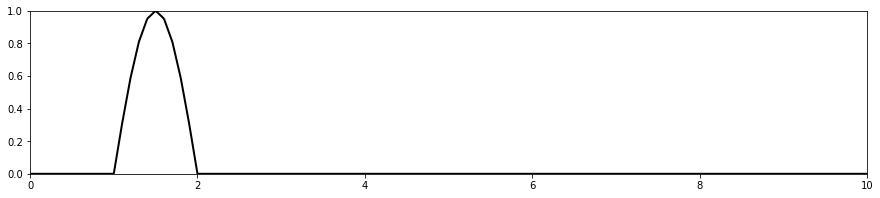

In [7]:
fig, axes = plt.subplots(figsize=(15, 3))
plot(c0, axes=axes)
axes.set_xlim([0, l])
axes.set_ylim([0, 1]);

In [8]:
u = Function(R).assign(1.0)
D = Constant(0.1)

In [9]:
# # SUPG stabilisation
# tau = 0.5*h/abs(u)
# phi = phi + tau*u*phi.dx(0)

In [10]:
a = c*phi*dx + theta*dt*u*c.dx(0)*phi*dx + theta*dt*D*c.dx(0)*phi.dx(0)*dx
L = c_*phi*dx - (1-theta)*dt*u*c_.dx(0)*phi*dx - (1-theta)*dt*D*c_.dx(0)*phi.dx(0)*dx
c = Function(P1)
bc = DirichletBC(P1, 0, 'on_boundary')

In [11]:
P0 = FunctionSpace(mesh, "DG", 0)
k = Function(P0)
k.interpolate(conditional(And(ge(x, 4), le(x, 4+h)), 1, 0))
J_form = dt*c*k*dx

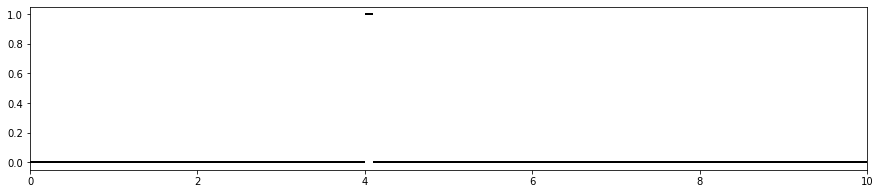

In [12]:
fig, axes = plt.subplots(figsize=(15, 3))
plot(k, axes=axes)
axes.set_xlim([0, l]);

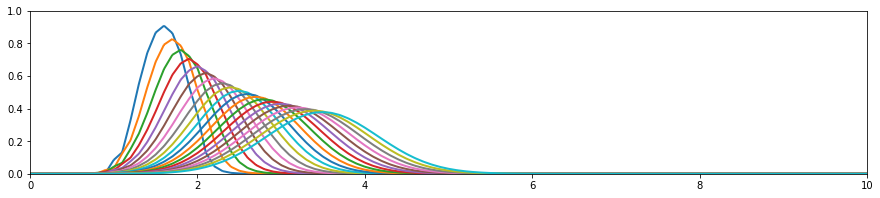

In [13]:
J = 0
fig, axes = plt.subplots(figsize=(15, 3))
for i in range(num_timesteps):
    J += assemble((1-theta)*J_form)
    solve(a == L, c, bcs=bc)
    c_.assign(c)
    J += assemble(theta*J_form)
    plot(c, axes=axes, edgecolor=f"C{i}")
axes.set_xlim([0, l])
axes.set_ylim([0, 1]);

In [14]:
stop_annotating();

In [15]:
Jhat = ReducedFunctional(J, Control(m))
gd = Jhat.derivative().dat.data[0]

In [16]:
tape = get_working_tape()
solve_blocks = [
    block
    for block in tape.get_blocks()
    if issubclass(type(block), GenericSolveBlock)
    and not issubclass(type(block), ProjectBlock)
]

In [17]:
cont_adj = Function(P1)
cont_adj_ = Function(P1)
a_star = adjoint(a)
L_star = theta*dt*k*phi*dx + replace(L, {phi: cont_adj_, c_: phi})

In [18]:
solve(a_star == L_star, cont_adj, bcs=bc)
cont_adj_.assign(cont_adj)
L_star += (1-theta)*dt*k*phi*dx

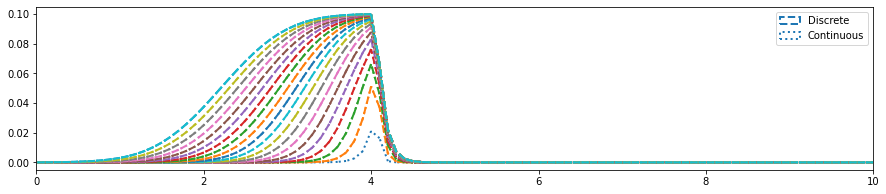

In [19]:
fig, axes = plt.subplots(figsize=(15, 3))
discrete_adj = solve_blocks[num_timesteps-1-i].adj_sol
plot(discrete_adj, axes=axes, linestyle='--', edgecolor=f"C0", label='Discrete')
plot(cont_adj, axes=axes, linestyle=':', edgecolor=f"C0", label='Continuous')

for i in range(1, num_timesteps):
    solve(a_star == L_star, cont_adj, bcs=bc)
    cont_adj_.assign(cont_adj)
    
    discrete_adj = solve_blocks[num_timesteps-1-i].adj_sol
    plot(discrete_adj, axes=axes, linestyle='--', edgecolor=f"C{i}")
    plot(cont_adj, axes=axes, linestyle=':', edgecolor=f"C{i}")
axes.set_xlim([0, l])
axes.legend();

In [20]:
print(f"Absolute L2 difference = {errornorm(cont_adj, discrete_adj)}")

Absolute L2 difference = 7.857833978946221e-17


In [21]:
gc = assemble(replace(L, {phi: cont_adj, c_: c0}))

In [22]:
print(f"Discrete gradient   = {gd}")
print(f"Continuous gradient = {gc}")

Discrete gradient   = 0.010583861817970452
Continuous gradient = 0.010583861817970459
